# Prediction of User Reactions
We want to predict:
* How to get high score/consensus (upvotes - downvotes)
* How to be controversial (upvotes + downvotes)  
in the comments.

### Import data

In [7]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').sample(100000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

### Prepare features

In [12]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# is empty: (= all comments correspond to an article)
#print(df_merge[pd.isnull(df_merge['link'])])
#df_merge[df_merge['vup']>1000]

# Get order of comments per article
df_merge_art = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')
# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    return group

df_merge_art = df_merge_art.apply(get_time_since_first)
print(df_merge_art.head(5))

            tId    cId  mob  vup  vdo                  tit             aut  \
85039  10003016    5_5    1  149   39                fake?          Müller   
85029  10003016  11_11    0   57  225   entführungsversuch           Natti   
85031  10003016   1_13    1  190   49  mein erster gedanke           H. M.   
85035  10003016  15_15    1  254   15             abgründe  Justitias Hand   
85036  10003016  27_27    1  405  118              darknet          Ben F.   

                      time                                                con  \
85039  am 08.08.2017 07:38   im text wird erwähnt das black death angebote...   
85029  am 08.08.2017 07:44   die sollen es nur ausprobieren was passiert, ...   
85031  am 08.08.2017 07:53   ich denke es auch nicht gerade förderlich wen...   
85035  am 08.08.2017 07:54   ich war schon beruflich im darknet unterwegs....   
85036  am 08.08.2017 07:59   das darknet ist schon beängstigend. das man n...   

       time_since_epoch        ...         c

### Trying to remove skew
__Rescaling__: Add or subtract a constant and then multiply or divide by a constant.  
__Normalizing__: Dividing by a norm of the vector, e.g. make Euclidean length equal to one. Sometimes make all elements lie in [0, 1].  
__Standardizing__: Subtracting a measure of location and dividing by a measure of scale. Eg. subtract the mean and divide by the std, thereby obtaining a standard normal distribution.

These terms are sometimes used interchangeably.

It's usually better to have the input values centered around zero, unless the output activation function has a range of [0, 1] (neural networks).

In [13]:
import math
def show_hist(col):
    df_merge_art['bins'] = pd.cut(df_merge_art[col], 100)
    h = df_merge_art.groupby(['bins']).size().plot.bar(title=col)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()
    
# This categories are defined randomly
bins = [-np.inf, 2, 25, np.inf]
labels = ['negative', 'small', 'big']
df_merge_art['score_cat'] = pd.cut(df_merge_art['score'], bins, labels=labels)
print(df_merge_art.groupby('score_cat').size())

# This doesn't change anything, which is interesting
#df = df[(df['score']<2) | (df['score']>=25)]
    
df = df_merge_art.copy(deep=True)
def sgn(x):
    if x == 0: return 0
    else: return x/abs(x)
# Removes left/right skew 
transformation = lambda x: sgn(x)*math.log(abs(x) + 1)
for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
    #min_val = df_merge_art[col].min()
    df[col + '_trans'] = df_merge_art[col].apply(transformation)
    #show_hist(col + '_trans')

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# I removed very weak correlations to "score" and "contr"
cols = ['score', 'score_trans', 'vup', 'vdo', 'weekday', 'hour', 'weekday_fl',
       'con_len_trans', 'text_len_trans', 'con_num_words_trans', 
        'text_num_words_trans',
       'time_since_first_trans', 'header_len_trans', 
        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland']
# Get pearson co-efficients
df[cols].corr()

#for c in cols:
#    print(c)
#    print(df[np.isnan(df[col])].head(3))

# TODO transform data for learners (non-linear probably)

score_cat
negative    32922
small       37742
big         30453
dtype: int64


,score,score_trans,vup,vdo,weekday,hour,weekday_fl,con_len_trans,text_len_trans,con_num_words_trans,...,cat_schweiz,cat_schweiz,cat_finance,cat_finance,cat_sport,cat_sport,cat_wissen,cat_wissen,cat_ausland,cat_ausland
score,1.000,0.470,0.958,0.098,-0.008,-0.009,-0.009,0.010,-0.003,0.008,...,0.033,0.033,-0.026,-0.026,-0.019,-0.019,-0.017,-0.017,0.002,0.002
score_trans,0.470,1.000,0.344,-0.321,-0.012,-0.013,-0.013,0.034,-0.004,0.031,...,0.021,0.021,-0.014,-0.014,-0.032,-0.032,-0.004,-0.004,-0.007,-0.007
vup,0.958,0.344,1.000,0.379,-0.005,-0.008,-0.006,0.016,-0.002,0.013,...,0.039,0.039,-0.038,-0.038,-0.013,-0.013,-0.024,-0.024,0.013,0.013
vdo,0.098,-0.321,0.379,1.000,0.010,0.000,0.010,0.022,0.002,0.021,...,0.029,0.029,-0.047,-0.047,0.017,0.017,-0.031,-0.031,0.040,0.040
weekday,-0.008,-0.012,-0.005,0.010,1.000,0.006,0.993,-0.006,-0.026,-0.007,...,0.013,0.013,-0.036,-0.036,0.004,0.004,0.009,0.009,-0.016,-0.016
hour,-0.009,-0.013,-0.008,0.000,0.006,1.000,0.123,-0.055,-0.027,-0.055,...,-0.052,-0.052,-0.009,-0.009,0.015,0.015,0.036,0.036,0.003,0.003
weekday_fl,-0.009,-0.013,-0.006,0.010,0.993,0.123,1.000,-0.012,-0.029,-0.014,...,0.007,0.007,-0.037,-0.037,0.005,0.005,0.013,0.013,-0.016,-0.016
con_len_trans,0.010,0.034,0.016,0.022,-0.006,-0.055,-0.012,1.000,0.065,0.989,...,0.045,0.045,0.034,0.034,-0.054,-0.054,-0.011,-0.011,0.019,0.019
text_len_trans,-0.003,-0.004,-0.002,0.002,-0.026,-0.027,-0.029,0.065,1.000,0.061,...,0.162,0.162,0.076,0.076,-0.025,-0.025,0.023,0.023,0.065,0.065
con_num_words_trans,0.008,0.031,0.013,0.021,-0.007,-0.055,-0.014,0.989,0.061,1.000,...,0.042,0.042,0.031,0.031,-0.049,-0.049,-0.012,-0.012,0.014,0.014


### Prepare and split for model

In [14]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
#stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
#stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
#stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

def classify(val):
    if val > 10: return 1
    return 0

X = df.drop(['score', 'contr', 'vup', 'vdo'], axis=1)

#y = df_merge_art['score'].apply(classify)
y = df['score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(len(X))

101117


### Model 

R^2: 0.080
Explained var: 0.080230
[ 52.03002595   6.08941943  96.08483447 ...,  35.47636101  97.01068867
   9.198613  ]


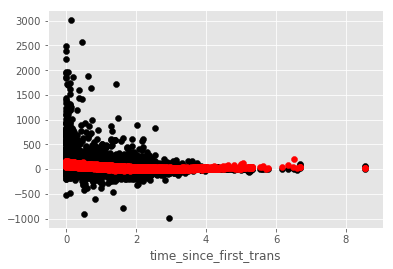

In [25]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, ElasticNet
#from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 'con_len_trans', 
                         'time_since_first_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                        ])),
                ('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=2)),
            ])),

            ('words', Pipeline([
                ('selector', ItemSelector(key='con')),
                ('tfidf', TfidfVectorizer(preprocessor=no_numbers)),
                ('best', TruncatedSVD(n_components=50)),
                #('anova', SelectKBest(f_regression, k=50))
            ])),
        ]
    )),    
#    ('model', DecisionTreeRegressor(max_depth=3))
    ('model', MLPRegressor(max_iter=10, hidden_layer_sizes=(100,)))
    #('model', SVC(kernel='linear', n_jobs=-1))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
print(y_pred)
#print(classification_report(y_test, y_pred))

# Residual plot
X_res = X_test['time_since_first_trans']
plt.scatter(X_res, y_test, color='black')
plt.scatter(X_res, y_pred, color='red')
plt.xlabel('time_since_first_trans')
plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'model__hidden_layer_sizes':[(50,), (100,), (200,), (100, 50)]
#        'model__max_depth': list(range(1, 20)),
#        'model__criterion': ['mse', 'friedman_mse', 'mae']
#        'model__alpha': np.logspace(-1, 4, 6),
                 }
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

### Summary so far
The decision tree regressor depends a lot on max_depth parameter: Depending on it, the model over- or underfits. I reached the best R^2 score with max_depth=3, but model underfits.

Neural networks work a bit better: R^2

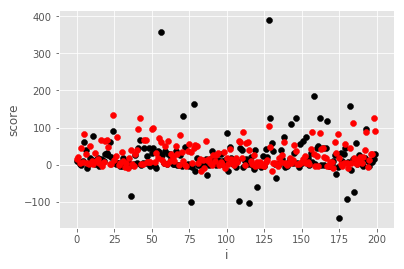

In [40]:
X_res = []; y_pred = []; y_act = []
#for i, item in df.sample(200).iterrows():
#    y_pred.append(model.predict([item]))
#    y_act.append(item['score'])
#    X_res.append(i)
n = 200
sample = df.sample(n)
y_pred = model.predict(sample)
y_act = sample['score']
X_res = list(range(0, n))
    
plt.scatter(X_res, y_act, color='black')
plt.scatter(X_res, y_pred, color='red')
plt.xlabel('i'); plt.ylabel('score')
plt.show()